## Tokenizing:

In [ ]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [ ]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [1]:
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

In [2]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [3]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [4]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang):
    lang_tokenizer = T.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

Using TensorFlow backend.


In [5]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [6]:
path_to_file_zh = r'H:\HLT\zh-Education.tok'
path_to_file_en = r'H:\HLT\en-Education.tok'

# Try experimenting with the size of that dataset
num_examples = 100#450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [7]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 839, 713


In [8]:
import numpy as np

# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Generate embedding vectors for <start> and <end> token
def initSpecialToken(vector_size, seed):
    np.random.seed(seed)
    return np.random.rand(vector_size)

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(num_tokens, trained_vector_path, vector_size):
    trained_word_vec = word2vec(trained_vector_path)
    print('number of trained word vector: {}:{}'.format(trained_vector_path, len(trained_word_vec)))

    embedding_matrix = np.zeros(num_tokens, vector_size)

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
import gzip
import os
import tarfile
import wget

# Download pre-trained Fasttext word embeddin
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz",out = r"G:\NLP\fasttext\cc.en.300.vec.gz")
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz",out = r"G:\NLP\fasttext\cc.zh.300.vec.gz")


# Uncompressing download files
def un_gz(file_name):
    """ungz zip file"""
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "w+").write(g_file.read())
    g_file.close()
    
%cd "G:\NLP\fasttext\"
un_gz("cc.en.300.vec.gz")
un_gz("cc.zh.300.vec.gz")

In [ ]:
import numpy as np

vector_size = 300
trained_vector_paths = (r'G:\NLP\fasttext\cc.zh.300.vec', r'G:\NLP\fasttext\cc.en.300.vec')

# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(trained_vector_paths[0], vector_size, num_encoder_tokens)
# Save input embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\input_emb_matrix', input_emb_matrix)

In [ ]:
# Creating output embedding vectors and specify the <start>, <end> token
output_emb_matrix = get_embedding_matrix(trained_vector_paths[1], vector_size, num_decoder_tokens)
start_token_vec = initSpecialToken(vector_size, 0) #'<start>'
end_token_vec = initSpecialToken(vector_size, 1) # '<end>'
output_emb_matrix[targ_lang.word_index['<start>']] = start_token_vec
output_emb_matrix[targ_lang.word_index['<end>']] = end_token_vec
# Save output embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\output_emb_matrix', output_emb_matrix)

In [9]:
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'H:\HLT\Embedding_Matrix\input_emb_matrix.npy'), np.load(r'H:\HLT\Embedding_Matrix\output_emb_matrix.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (145824, 300), (210721, 300)


In [10]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 80, 20


In [11]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 46, 42


In [12]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size = 5):
    #zero padding all sequences
    encoder_input_tensor = S.pad_sequences(input_tensor,padding='post', maxlen = max_length_inp)
    # decoder input sequence does not include the <end> token
    decoder_input_tensor = S.pad_sequences([s[:-1] for s in target_tensor],padding='post', maxlen = max_length_targ)
    # decoder target sequence (one hot encoded) does not include the <START> token, Offset by one timestep
    decoder_target_tensor = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in target_tensor],padding='post', maxlen = max_length_targ)])

    # Generate a batch of data
    while True:
        for i in range(0, len(input_tensor), batch_size):
            encoder_input_batch = encoder_input_tensor[i:i + batch_size]
            decoder_input_batch = decoder_input_tensor[i:i + batch_size]
            decoder_target_batch = decoder_target_tensor[i:i + batch_size]
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [13]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [14]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

batch_size = 5#128
latent_dim = 300
# Set up the encoder
encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
print(encoder_inputs.shape, enc_emb.shape)
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

(5, 46) (5, 46, 300)


In [15]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
print(decoder_inputs.shape, dec_emb.shape)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder GRU output
print(decoder_outputs.shape,attn_out.shape)
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# Dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
decoder_outputs = dense_time(decoder_concat_input)

(5, 42) (5, 42, 300)
(5, 42, 600) (5, 42, 600)


In [16]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (5, 46)              0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (5, 46, 300)         251700      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (5, 42)              0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(5, 46, 600), (5, 3 1081800     embedding[0][0]                  
__________________________________________________________________________________________________
embedding_

In [17]:
!apt install graphviz
!pip install pydot pydot-ng

'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


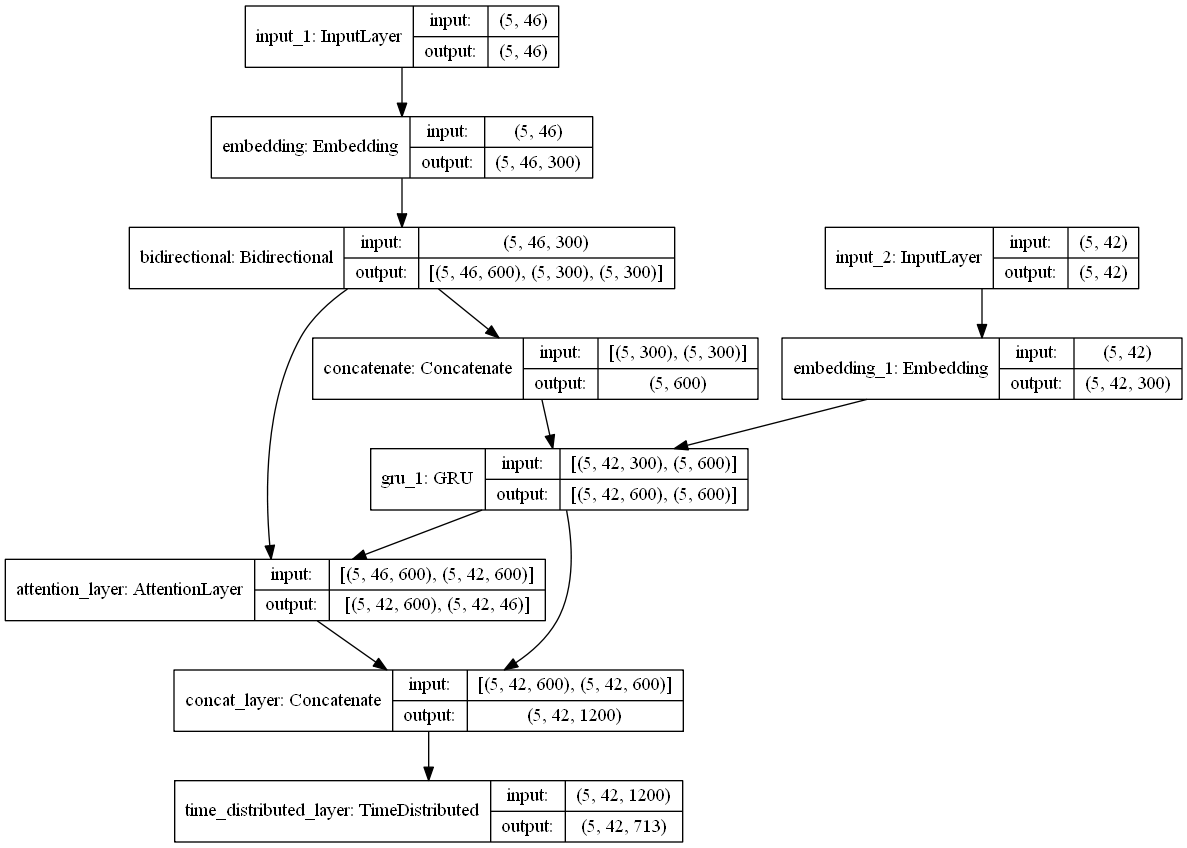

In [18]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [19]:
# Start training
epochs = 40#100
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/40
16/16 [==============================] - 51s 3s/step - loss: 3.3545 - acc: 0.5036 - val_loss: 3.0285 - val_acc: 0.5226
Epoch 2/40
16/16 [==============================] - 47s 3s/step - loss: 2.5960 - acc: 0.5622 - val_loss: 3.0725 - val_acc: 0.5369
Epoch 3/40
16/16 [==============================] - 47s 3s/step - loss: 2.4380 - acc: 0.5726 - val_loss: 3.1415 - val_acc: 0.5381
Epoch 4/40
16/16 [==============================] - 47s 3s/step - loss: 2.3115 - acc: 0.5807 - val_loss: 3.2498 - val_acc: 0.5429
Epoch 5/40
16/16 [==============================] - 47s 3s/step - loss: 2.1765 - acc: 0.5845 - val_loss: 3.3320 - val_acc: 0.5524
Epoch 6/40
16/16 [==============================] - 47s 3s/step - loss: 2.0579 - acc: 0.5899 - val_loss: 3.5448 - val_acc: 0.5571
Epoch 7/40
16/16 [==============================] - 47s 3s/step - loss: 2.0018 - acc: 0.5920 - val_loss: 3.6453 - val_acc: 0.5560
Epoch 8/40
16/16 [==============================] - 47s 3s/step - loss: 1.9236 - acc: 0.59

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


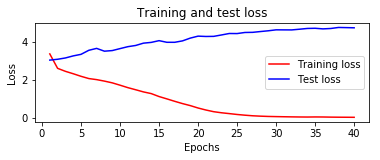

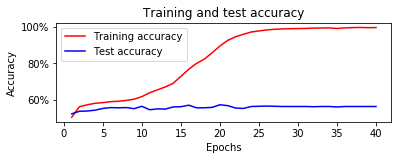

In [20]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [19]:
# Save weights
model.save_weights('nmt_bigru_embedding_weights_100epochs.h5')

In [20]:
# Load weights
model.load_weights('nmt_bigru_embedding_weights_100epochs.h5')

In [24]:
# Inference model
batch_size = 1

# Encoder (Inference) model
encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
# Encode the input sequence to get the "Context vectors"
encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])

# Decoder (Inference) model
decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
# Get the embeddings of the decoder sequence
dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
# Final decoder model
decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],
                        outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

In [25]:
# Encoder model summary
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay (1, 46)                   0         
_________________________________________________________________
embedding (Embedding)        multiple                  251700    
_________________________________________________________________
bidirectional (Bidirectional multiple                  1081800   
Total params: 1,333,500
Trainable params: 1,081,800
Non-trainable params: 251,700
_________________________________________________________________


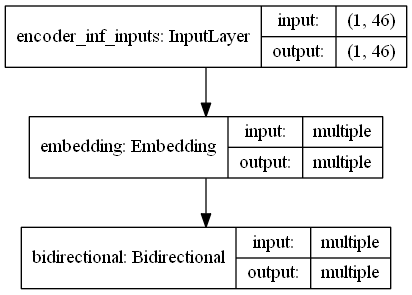

In [26]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [27]:
# Decoder model summary
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_word_inputs (InputLayer (1, 1)               0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             213900      decoder_word_inputs[0][0]        
__________________________________________________________________________________________________
decoder_init (InputLayer)       (1, 600)             0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     multiple             1621800     embedding_1[2][0]                
                                                                 decoder_init[0][0]               
__________

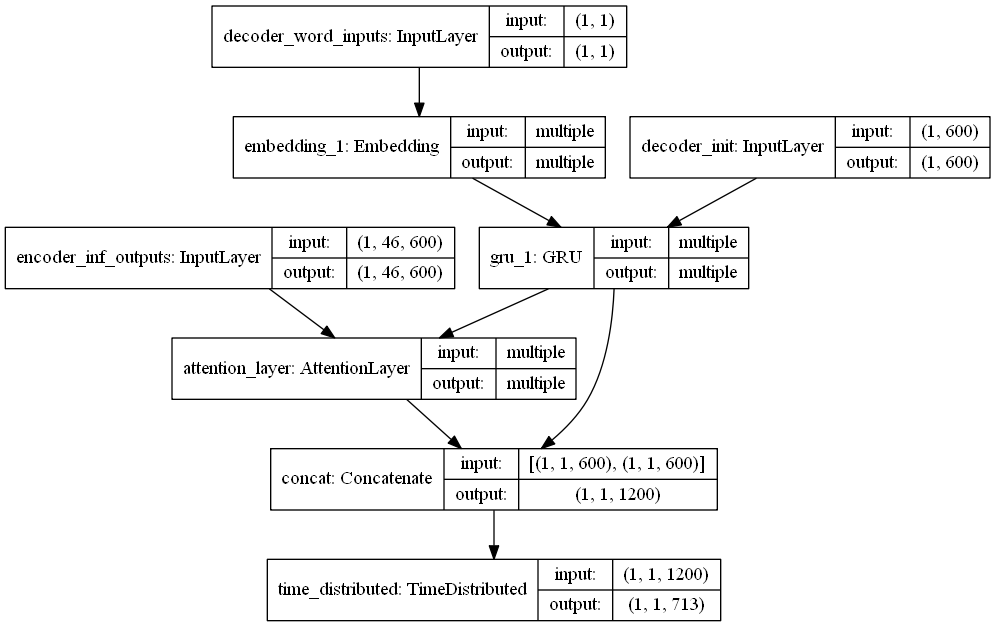

In [28]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [36]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = targ_lang.word_index['<start>']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    count = 0
    attention_weights = []
    while not stop_condition:
        output_tokens, attention, states_value = decoder_model.predict([enc_outs, states_value, target_seq])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_word_targ[sampled_token_index]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '<end>' or count > max_length_targ):
            stop_condition = True
            count = 0
        else:
            attention_weights.append((sampled_token_index, attention))
            decoded_sentence += ' '+ sampled_word
            count += 1
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
    return decoded_sentence[1:],attention_weights

In [122]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    # Encode the input as state vectors.
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    #print("input_seq",input_seq.shape, states_value.shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = targ_lang.word_index['<start>']
    # Final k predicted sentence
    decoded_sentence = ["" for x in range(k)]
    attention_weights = [[] for x in range(k)]
    # Probabilities of each k candidates token in the sentence
    prop = [[0 for x in range(k)] for y in range(max_length_targ)]
    # Index of each k candidates token in the sentence 
    sampled_token_index = [[0 for x in range(k)] for y in range(max_length_targ)]
    # Sampled word of each k candidates token in the sentence 
    sampled_word = [["" for x in range(k)] for y in range(max_length_targ)]
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for l in range(max_length_targ):
        for i in range(k):
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, states_value, target_seq])
            #print("output_tokens",output_tokens.shape, states.shape)
            # Sort Probabilities for candidates, get the indices 
            sampled_token_index[l][i] =  np.argsort(output_tokens[0, -1, :])[-(i+1)]
            # Sample words from index
            if sampled_token_index[l][i] != 0:
                sampled_word[l][i] = index_word_targ[sampled_token_index[l][i]]
            else:
                # error : No word was sampled
                #print(i,sampled_token_index[l][i],np.argsort(output_tokens[0, -1, :]))
                sampled_word[l][i] = ''
            # Mutiply Probabilities with previous setp
            prop[l][i] = (max(prop[l-1][:]) if l>0 else 0) + np.log(output_tokens[0, -1, sampled_token_index[l][i]])

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        # Sort candidates index by accumulated Probabilities
        prop_indices = np.argsort(prop[l][:])[::-1]

        # Stop sampling if we meet the '<end>' token which has the max Probability
        if sampled_word[l][prop_indices[0]] == '<end>':
            break

        # Forming k predicted sentence
        for idx in range(k):
            decoded_sentence[idx] += (' ' if l > 0 else '') + sampled_word[l][prop_indices[idx]]
            attention_weights[idx].append((sampled_token_index[l][prop_indices[idx]], attention))

         # Update states for next step       
        target_seq[0, 0] = sampled_token_index[l][prop_indices[0]]
    return decoded_sentence, attention_weights

In [30]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [115]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(32, 32))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    #ax.set_xticks(np.arange(attention_mat.shape[1]))
    #ax.set_yticks(np.arange(attention_mat.shape[0]))
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    #ax.set_yticklabels([index_word_inp[inp] if inp != 0 else "<Res>" for inp in encoder_inputs.ravel()])
    #ax.set_xticklabels([index_word_targ[inp] if inp != 0 else "<Res>" for inp in dec_inputs])
    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())])
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=26)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))

In [31]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

Input Source sentence: 你 如果 能 正确 和 有效 地 使用 一 个 字 ， 你 就 了解 它 了 。
Actual Target Translation: if you can use a word correctly and effectively , you comprehend it .
Predicted Target Translation: if you can use a word correctly and effectively , you comprehend it .


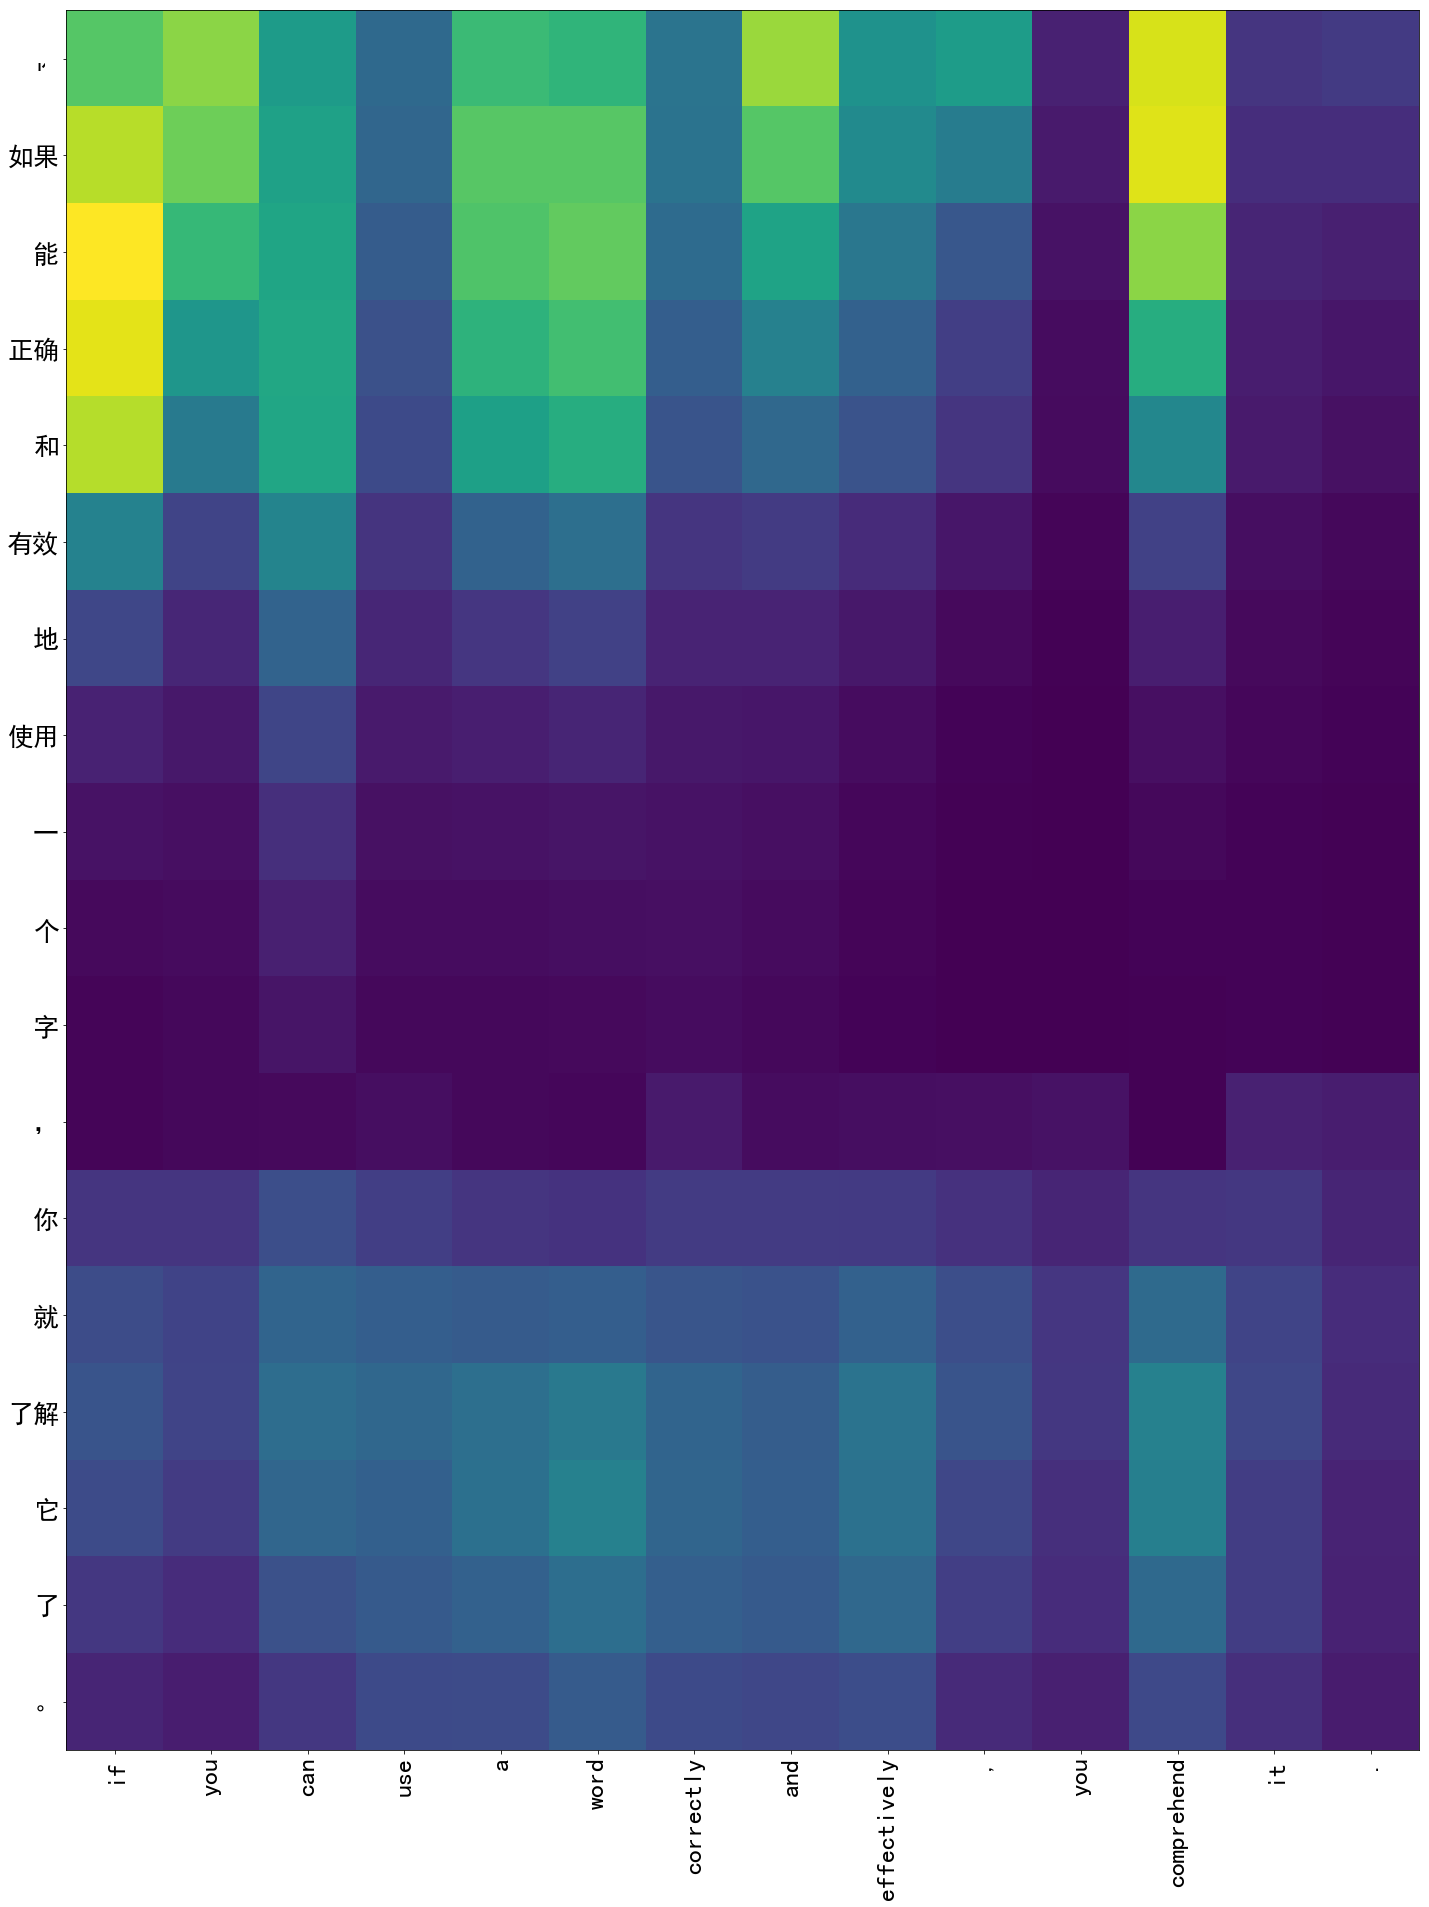

In [126]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence, attn_weights = decode_sequence(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence)
# Attention plotting
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, attn_weights, index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(decoded_sentence[0:10]))

Input Source sentence: 听到 这样 的 评论 我 感到 震惊 ， 但是 后来 我 发现 ， 对于 开发 和 测试 团体 来说 ， 这 是 一 个 普遍 存在 的 观点 。
Actual Target Translation: i was a bit taken aback by this comment , but later on i realized that this general belief was fairly prevalent in both the development and testing communities at large .
Predicted Target Translation: i was taken i just that dependence was to , but are posters on or my song on the radio , it s not .


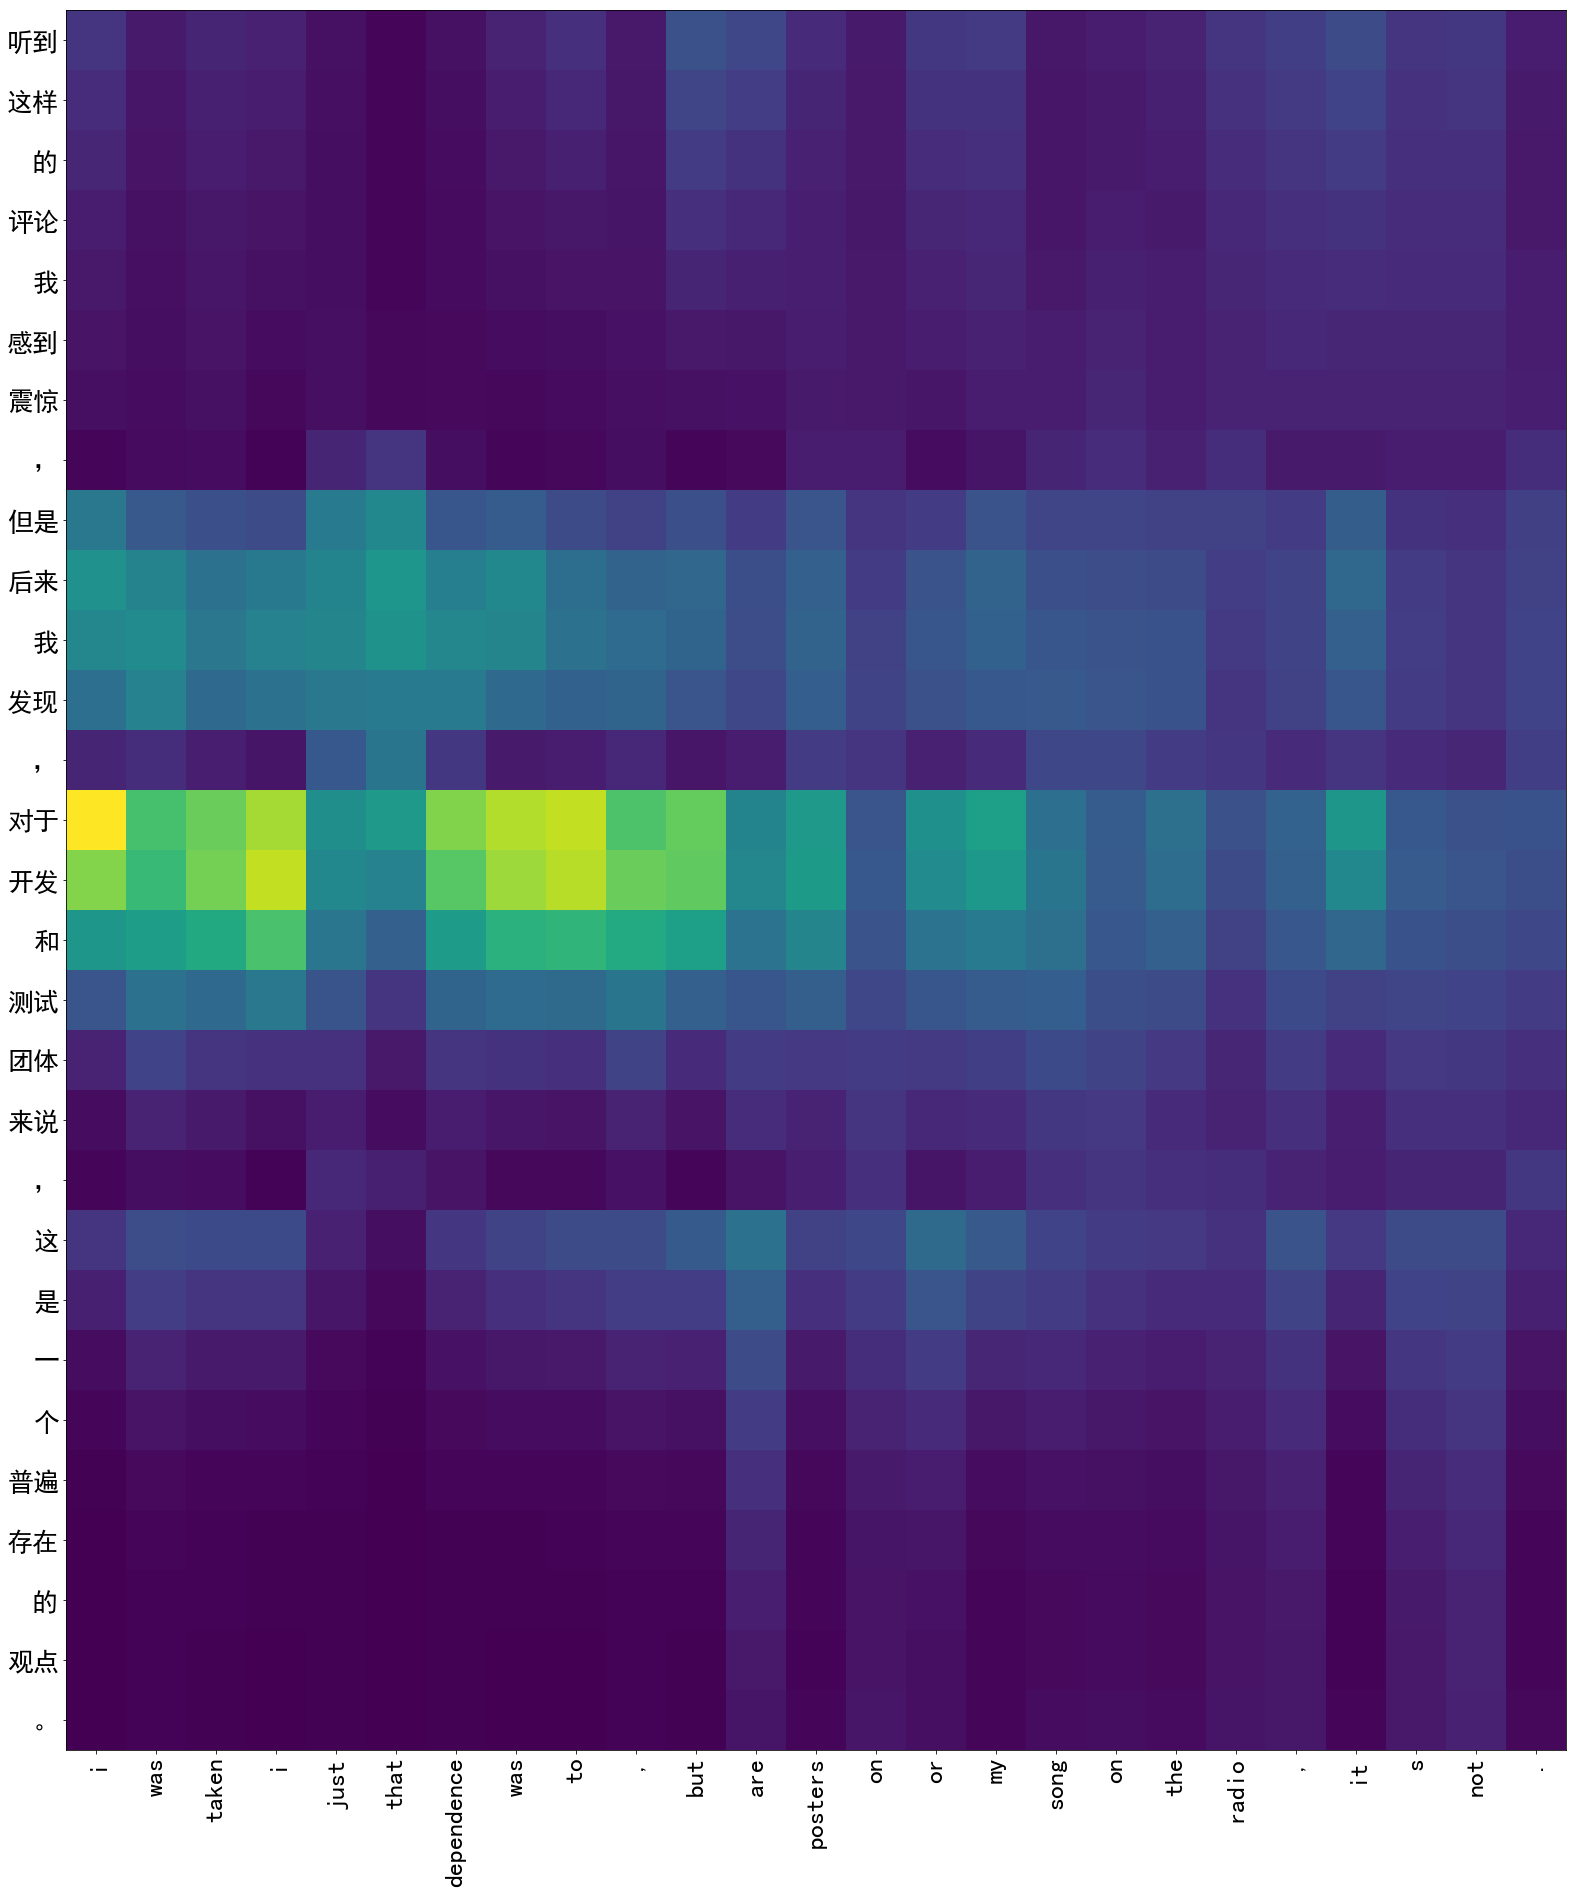

In [133]:
decoded_sentence, attn_weights = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence[0])
# Attention plotting
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, attn_weights[0], index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(decoded_sentence[0][0:10]))

In [71]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

Input Source sentence: 接下来 ， 在 根用户 的 终端 上 列出 tmp 的 内容 清单 注意 ， 这里 有 其他 文件 ， 但是 没有 tmp ab 。
Actual Target Translation: next , get a listing of the tmp contents in the root terminal notice that there are likely other files but no tmp ab .
Predicted Target Translation: but he might be taken aback by the popular sympathy for his plight .


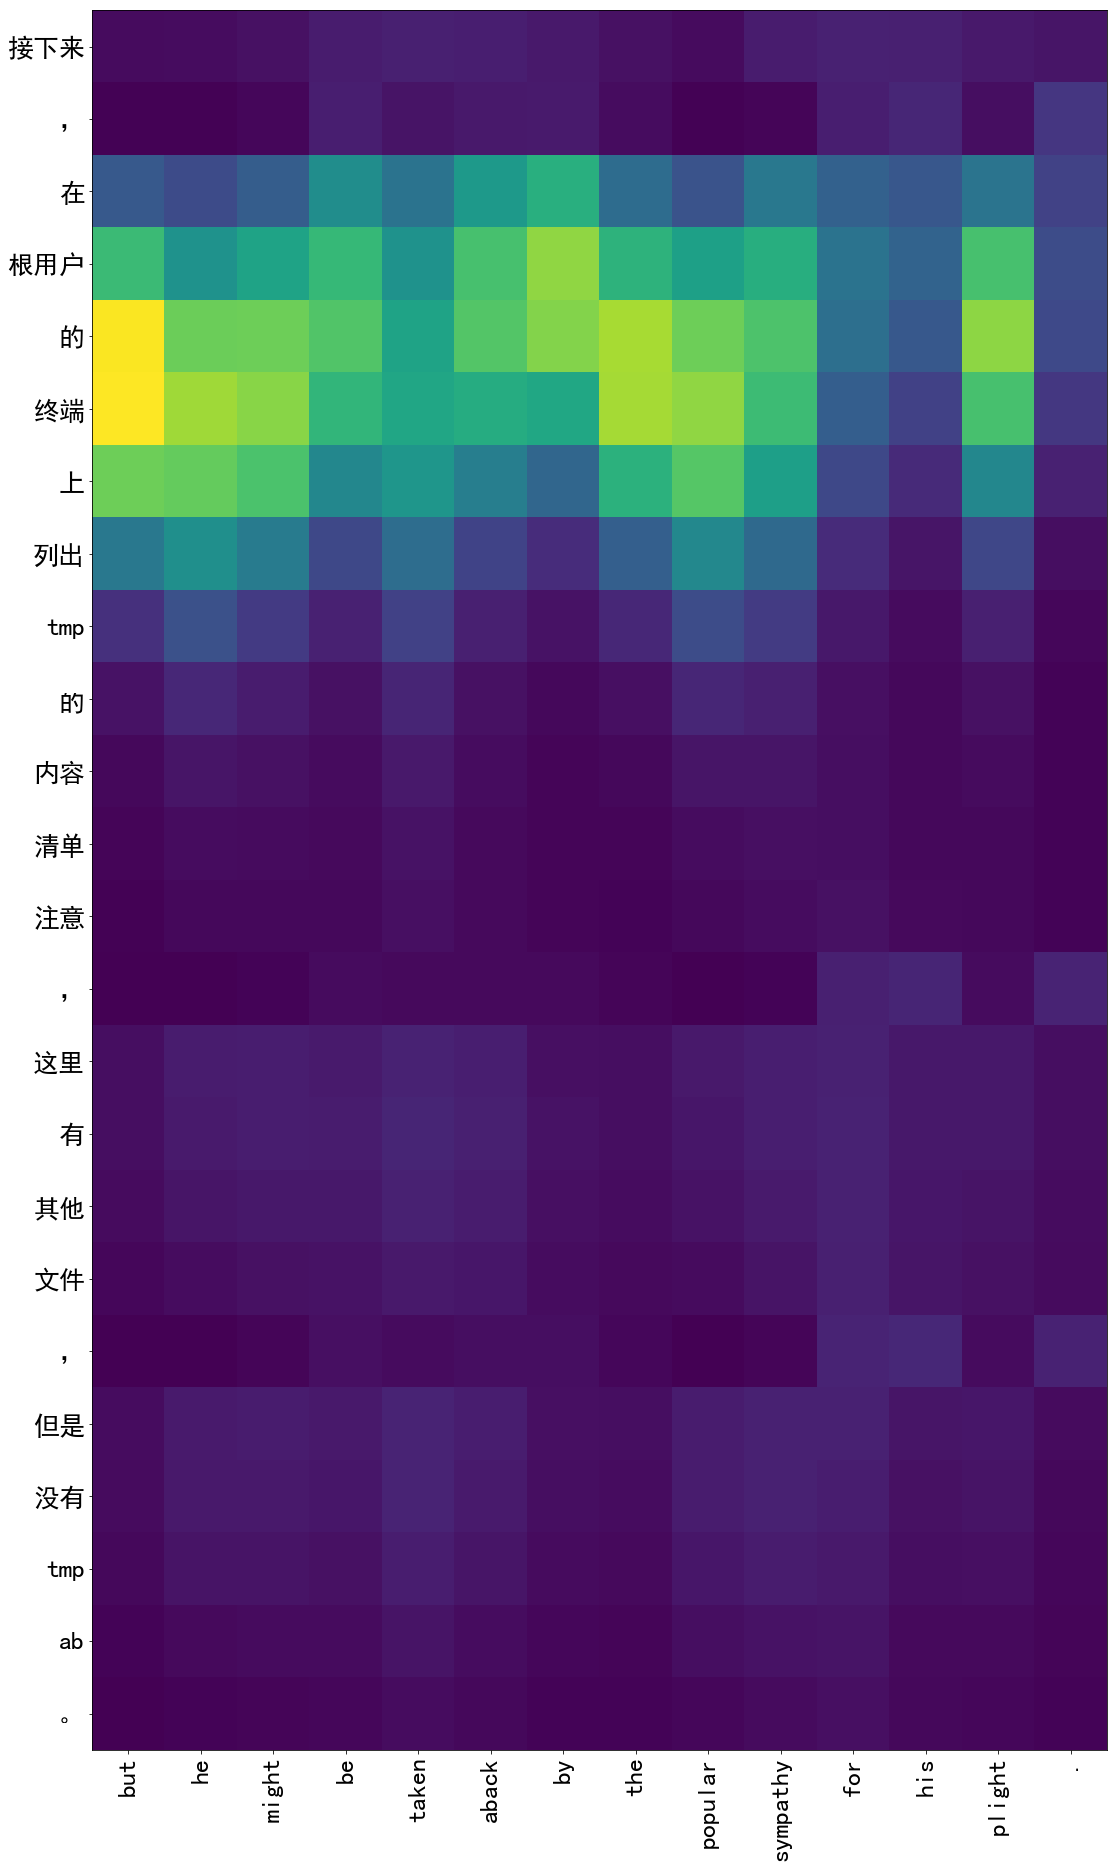

In [128]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence, attn_weights = decode_sequence(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence)
# Attention plotting
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, attn_weights, index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(decoded_sentence[0:10]))

Input Source sentence: 接下来 ， 在 根用户 的 终端 上 列出 tmp 的 内容 清单 注意 ， 这里 有 其他 文件 ， 但是 没有 tmp ab 。
Actual Target Translation: next , get a listing of the tmp contents in the root terminal notice that there are likely other files but no tmp ab .
Predicted Target Translation: but might an by the popular sympathy the abacus and the                               


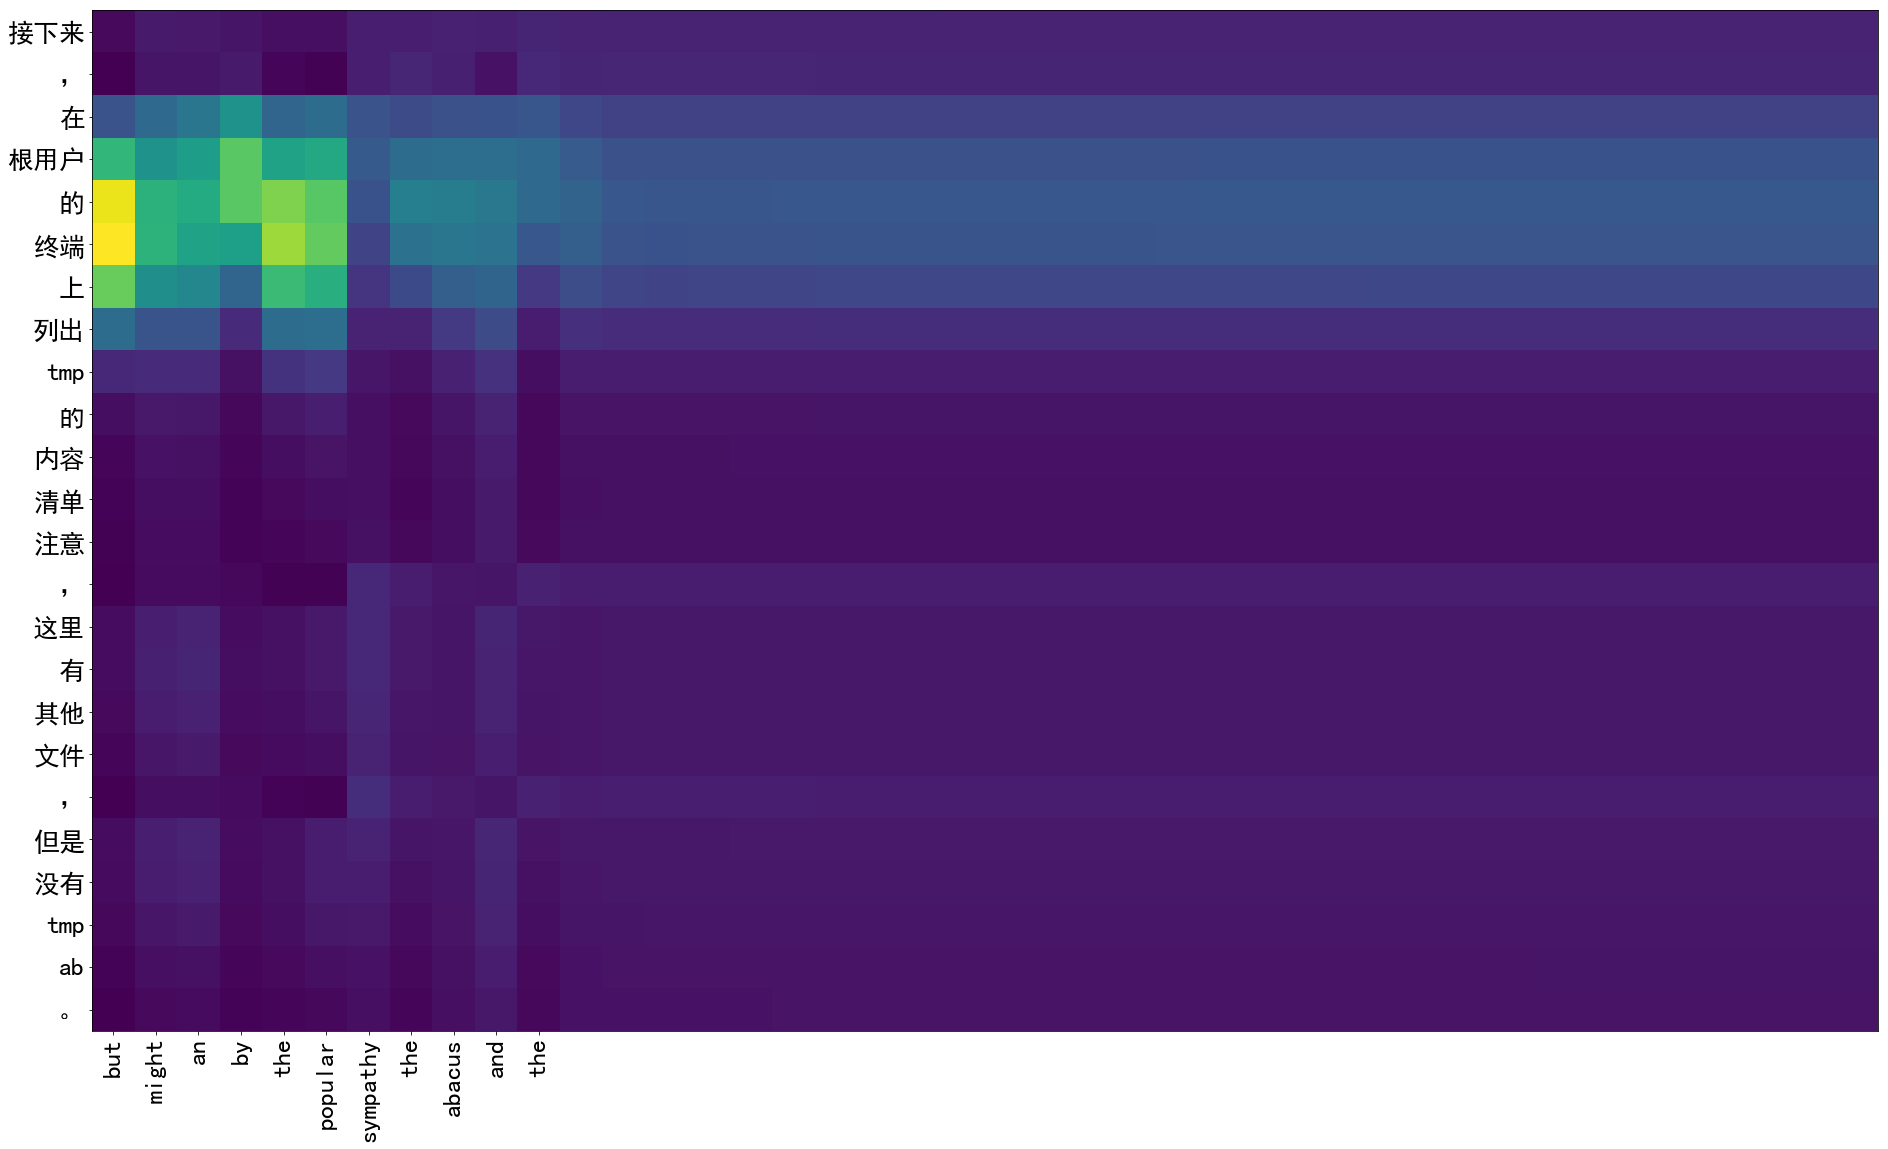

In [130]:
decoded_sentence, attn_weights = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence[0])
# Attention plotting
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']
plot_attention_weights(input_seq, attn_weights[0], index_word_inp, index_word_targ, base_dir=r"H:\HLT", filename='attention_{}.png'.format(decoded_sentence[0][0:10]))

In [134]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
test = [token for token in decoded_sentence[0].split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['i', 'was', 'taken', 'i', 'just', 'that', 'dependence', 'was', 'to', ',', 'but', 'are', 'posters', 'on', 'or', 'my', 'song', 'on', 'the', 'radio', ',', 'it', 's', 'not', '.']
Reference - Actual Target Translation: [['i', 'was', 'a', 'bit', 'taken', 'aback', 'by', 'this', 'comment', ',', 'but', 'later', 'on', 'i', 'realized', 'that', 'this', 'general', 'belief', 'was', 'fairly', 'prevalent', 'in', 'both', 'the', 'development', 'and', 'testing', 'communities', 'at', 'large', '.']]
Bleu score: 4.933301046640254e-155


In [140]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence, _ = decode_sequence(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence.split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence)
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 80

Input Source sentence: 旅馆 招待员 想知道 我们 明天 早上 什么 时候 离开 。
Actual Target Translation: the hotel receptionist wants to know when we will be checking out tomorrow morning .
Predicted Target Translation: the hotel receptionist wants to know when we will be checking out tomorrow morning .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 80

Input Source sentence: 算盘 和 十字架 可以 用来 纠正 流行 的 偏见 ， 但 仅仅 靠 这些 是 远远 不 够 的 。
Actual Target Translation: the abacus and the cross is a useful corrective to popular prejudice , but it does not go far enough .
Predicted Target Translation: the abacus and the cross is a useful corrective to popular prejudice , but it does not go far enough .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 80

Input S

Sample: 18 in total number of 80

Input Source sentence: 在 我 最初 被 这 群 消极 人类 弄得 措手不及 的 同时 ， 我 终于 学会 了 处理 这 事儿 并且 把 它 引导 成 自觉 行为 。
Actual Target Translation: while i was initially taken aback by negativity of the people , i eventually learned to manage it and channel it into conscious action .
Predicted Target Translation: while i was initially taken aback by negativity of the people , i eventually learned to manage it and channel it into conscious action .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 19 in total number of 80

Input Source sentence: ab 工具 易于 使用 只 需 提供 给 它 一 个 重复 数和 一 个 url 。
Actual Target Translation: the ab utility is simple to use provide a repeat count and a url .
Predicted Target Translation: the ab utility is simple to use provide a repeat count and a url .
Bleu score: 1.0
-----------------------------------------------------------------------------------------------

Sample: 37 in total number of 80

Input Source sentence: 我们 宁愿 住 郊区 而 不 愿 住 城里 。
Actual Target Translation: we would rather live in the suburbs than in the city .
Predicted Target Translation: we would rather live in the suburbs than in the city .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 38 in total number of 80

Input Source sentence: 我 在 高中 学的 是 数学 微积分 ab 不 是 bc ， 我 得了 4 分 在 数学 微积分 考试 ap 中 不 是 5 分 。
Actual Target Translation: i had taken ab calculus during high school not bc , and had scored a 4 on the ap exam not a 5 .
Predicted Target Translation: i had taken ab calculus during high school not bc , and had scored a 4 on the ap exam not a 5 .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 39 in total number of 80

Input Source sentence: 既然 你 不 愿意 帮 我 的 忙 ， 我 就 要 自己 一 个 人 干 这个 工作 。
A

Sample: 54 in total number of 80

Input Source sentence: 全 社会 都 应 关心 孩子 的 健康 成长 。
Actual Target Translation: the whole society should be concerned about the health and sound growth of children .
Predicted Target Translation: the whole society should be concerned about the health and sound growth of children .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 55 in total number of 80

Input Source sentence: 球上 成千上万 的 小 灯 开始 闪烁 的 那 一 刻 ， 人们 全都 欢呼 。
Actual Target Translation: they ooh and aah when the thousands of little lights in the ball come on .
Predicted Target Translation: they ooh and aah when the thousands of little lights in the ball come on .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 56 in total number of 80

Input Source sentence: 不管 项链 如何 漂亮 ， 我们 认为 价钱 太贵 ， 还是 没有 买它 。
Actual Targe


Input Source sentence: 毫 无 疑问 ， 你 肯定 想 知道 我 离开 学校 以来 的 情况 。
Actual Target Translation: no doubt you would like to know how i have been getting along since i left school .
Predicted Target Translation: no doubt you would like to know how i have been getting along since i left school .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 72 in total number of 80

Input Source sentence: 车上 装备有 霰弹枪 催泪弹 一 部 夜视 摄像机 和 几 包 和 奥巴马 同型 的 ab 型 血 。
Actual Target Translation: it is equipped with shotguns , tear gas , a night vision camera and bags of obama s blood group ab .
Predicted Target Translation: it is equipped with shotguns , tear gas , a night vision camera and bags of obama s blood group ab .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 73 in total number of 80

Input Source sentence: 我 可以 用纸 笔 写作 

In [138]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence, _ = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence[0].split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence[0])
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 80

Input Source sentence: 旅馆 招待员 想知道 我们 明天 早上 什么 时候 离开 。
Actual Target Translation: the hotel receptionist wants to know when we will be checking out tomorrow morning .
Predicted Target Translation: the new receptionist to lao of of morning .
Bleu score: 3.931442589445911e-155
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 80

Input Source sentence: 算盘 和 十字架 可以 用来 纠正 流行 的 偏见 ， 但 仅仅 靠 这些 是 远远 不 够 的 。
Actual Target Translation: the abacus and the cross is a useful corrective to popular prejudice , but it does not go far enough .
Predicted Target Translation: the last few , device , her , had taken aback .
Bleu score: 6.085166479973199e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 80

Input Source sentence: 一 发现 起火 ， 警报器 就 响 起来 。
Actual Target Trans

Sample: 19 in total number of 80

Input Source sentence: ab 工具 易于 使用 只 需 提供 给 它 一 个 重复 数和 一 个 url 。
Actual Target Translation: the ab utility is simple to use provide a repeat count and a url .
Predicted Target Translation: the ab utility , many , count url . morning .
Bleu score: 3.117598395941269e-78
-------------------------------------------------------------------------------------------------------------------------
Sample: 20 in total number of 80

Input Source sentence: 自从 开始 下雨 以来 ， 我 的 伤口 一直 在 疼 。
Actual Target Translation: my wound has been aching ever since it started to rain .
Predicted Target Translation: my has aching since you to .
Bleu score: 8.581461965017803e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 21 in total number of 80

Input Source sentence: 一些 评论 说 ， 用 算盘 计算 和 使用 计算器 毫 无 两样 ， 但是 ， 事实 并不 是 这样 。
Actual Target Translation: some might argue that dependence on an abacus is 

Sample: 38 in total number of 80

Input Source sentence: 我 在 高中 学的 是 数学 微积分 ab 不 是 bc ， 我 得了 4 分 在 数学 微积分 考试 ap 中 不 是 5 分 。
Actual Target Translation: i had taken ab calculus during high school not bc , and had scored a 4 on the ap exam not a 5 .
Predicted Target Translation: i was taken aback of the rude exam the abacus and a had for .
Bleu score: 8.544394984127022e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 39 in total number of 80

Input Source sentence: 既然 你 不 愿意 帮 我 的 忙 ， 我 就 要 自己 一 个 人 干 这个 工作 。
Actual Target Translation: since you won t help me , i must do the work myself .
Predicted Target Translation: since won help by the people myself eventually .
Bleu score: 9.445192131053245e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 40 in total number of 80

Input Source sentence: 它 树立 了 披露 行为 的 新 标准 ， 他 表示 ，

Sample: 56 in total number of 80

Input Source sentence: 不管 项链 如何 漂亮 ， 我们 认为 价钱 太贵 ， 还是 没有 买它 。
Actual Target Translation: beautiful though the necklace was , we thought it was over priced so we didn t buy it .
Predicted Target Translation: beautiful have the new businese building our are to be moved .
Bleu score: 7.188774785137329e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 57 in total number of 80

Input Source sentence: 比如说 我 去 超市 ， 想 添置 些 内裤 袜子 什么 的 ， 但是 那里 到处 都 是 我 的 海报 ， 广播 里面 播放 着 我 的 歌曲 ， 就是 这样 ， 哎 ！
Actual Target Translation: like , i go to walmart and i just want to go get some boxers and socks , but there are posters of me everywhere. or my song comes on the radio , and it s like , aah ! .
Predicted Target Translation: like , like , like abc i realized by the development and communities .
Bleu score: 1.1806371237713598e-155
--------------------------------------------------------------

Sample: 74 in total number of 80

Input Source sentence: ab 用 于 为 php 页面 自动化 处理 大量 的 请求 。
Actual Target Translation: use ab to automate a large number of requests for php pages .
Predicted Target Translation: use to a number of examinations .
Bleu score: 3.891753213047682e-155
-------------------------------------------------------------------------------------------------------------------------
Sample: 75 in total number of 80

Input Source sentence: 这 次 新 展览 展出 的 一些 作品 可能 会 让 前来 观展 的 骨灰 级 科幻迷们 大吃一惊 。
Actual Target Translation: descending into the new exhibition , hard core science fiction fans may be taken aback at some of the work around them .
Predicted Target Translation: descending into to do a night vision and bags s blood .
Bleu score: 2.3158251789104014e-155
-------------------------------------------------------------------------------------------------------------------------
Sample: 76 in total number of 80

Input Source sentence: 注意 ， 在 解析 器 寻找 末尾 的 单词 之前 ， 会 尝试 abc ab a 

In [148]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence, _ = decode_sequence(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence[0].split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence)
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 20

Input Source sentence: 我 到 得很 早 ， 以免 错过 什么 。
Actual Target Translation: i arrived early in order that i might not miss anything .
Predicted Target Translation: the alarm was raised as soon as the fire was discovered .
Bleu score: 0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 20

Input Source sentence: 那 真 是 一 个 神奇 的 地方 ， ab 说 ， 但是 我们 住 的 酒店 很 糟糕 ， 而且 每天 都 吃 同样 的 食物 。 早餐 面条 晚餐 米饭 ， 千篇一律 。
Actual Target Translation: it s an amazing place , ab said , but our hotel room was filthy and we ate the same thing every day. noodles for breakfast and rice for dinner .
Predicted Target Translation: it s an amazing place , ab said , but our hotel room was filthy and we ate the same thing every day .
Bleu score: 0
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 

Sample: 18 in total number of 20

Input Source sentence: 前列腺 非典型性 腺瘤 样 增生 腺病 前列腺 针刺 穿刺 标本 中 有时 会 见到 ， 为 良性 病变 ， 容易 与 前列 腺癌 混淆 。
Actual Target Translation: atypical adenomatous hyperplasia adenosis when seen in a needle biopsy is one of the most challenging benign mimics of cancer. a partially sampled focus of cancer may be mistaken for aah.
Predicted Target Translation: an abacus is essentially an array of beads threaded on string or held in grooves , with each row representing a different digit .
Bleu score: 1.7048016869801524e-244
-------------------------------------------------------------------------------------------------------------------------
Sample: 19 in total number of 20

Input Source sentence: 关于 你 的 秘密 ， 我 决 不 会 向 别人 泄露 一 个 字 的 。
Actual Target Translation: i will not breathe a word of your secret to another man .
Predicted Target Translation: no doubt you would like to know how i have been getting along since i left school .
Bleu score: 0
-------------------------------

In [149]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence, _ = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in decoded_sentence[0].split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', decoded_sentence[0])
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 20

Input Source sentence: 我 到 得很 早 ， 以免 错过 什么 。
Actual Target Translation: i arrived early in order that i might not miss anything .
Predicted Target Translation: the alarm was as as was , it .
Bleu score: 7.536728468577135e-232
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 20

Input Source sentence: 那 真 是 一 个 神奇 的 地方 ， ab 说 ， 但是 我们 住 的 酒店 很 糟糕 ， 而且 每天 都 吃 同样 的 食物 。 早餐 面条 晚餐 米饭 ， 千篇一律 。
Actual Target Translation: it s an amazing place , ab said , but our hotel room was filthy and we ate the same thing every day. noodles for breakfast and rice for dinner .
Predicted Target Translation: it s an , , but are ab on ab , ab when a when that is there to find .
Bleu score: 1.909044198871686e-78
-------------------------------------------------------------------------------------------------------------------------
Sample: 2 in total number of 20

Input Source s

Sample: 19 in total number of 20

Input Source sentence: 关于 你 的 秘密 ， 我 决 不 会 向 别人 泄露 一 个 字 的 。
Actual Target Translation: i will not breathe a word of your secret to another man .
Predicted Target Translation: no doubt like , i some been getting along tim .
Bleu score: 9.918706012922318e-232
-------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------
Average Bleu score: 1.909044198871686e-78/20 = 9.545220994358429e-80
